#**Ensemble_models**

Purpose:
- Train LightGBM and XGBoost models on safe FE dataset.
- Evaluate performance with time-based splits.
- Compare with LSTM forecasts.
- Explore hybrid ensemble methods (simple averaging, weighted).
- Save results under: `sandbox/models_ensemble/`.


#Cell 1 – Imports & Paths


In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJ = Path("/content/drive/MyDrive/player_value_prediction_project")
SAFE_FE = PROJ / "data" / "processed" / "master" / "sandbox" / "final_training_master_fe_safe.csv"
ENSEMBLE_DIR = PROJ / "data" / "processed" / "master" / "sandbox" / "models_ensemble"
ENSEMBLE_DIR.mkdir(parents=True, exist_ok=True)

print("Safe FE dataset:", SAFE_FE)
print("Ensemble outputs:", ENSEMBLE_DIR)


Safe FE dataset: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe_safe.csv
Ensemble outputs: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble


#Cell 2 – Load dataset + sanity check
This cell loads the safe FE dataset and checks shape, key columns, and missingness.

In [2]:
# Cell 2 – Load dataset + sanity check

# Load safe FE dataset
df = pd.read_csv(SAFE_FE, low_memory=False)
print("Loaded shape:", df.shape)

# Preview first rows
display(df.head(3))

# Check presence of key columns
expected_cols = ['player_id', 'season', 'target_log1p']
for col in expected_cols:
    print(f"{col} present?:", col in df.columns)

# Quick null percentage check
nulls = df.isna().mean().sort_values(ascending=False).head(15) * 100
print("\nTop 15 features by % missing:")
display(nulls)


Loaded shape: (87223, 176)


,season,name,age_at_season_start,position,sub_position,played_any,appearances_count,total_minutes,minutes_per_appearance,goals,...,goals_per90_scaled,assists_per90_scaled,goals_per_min_scaled,sb_xg_scaled,sb_shots_scaled,sb_passes_scaled,reddit_mean_compound_scaled,num_injuries_scaled,transfers_sum_fee_scaled,days_since_last_transfer_scaled
0,2012,Miroslav Klose,34.0,Attack,Centre-Forward,1,36,2585,71.805556,16,...,0.768854,0.020280,0.768854,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
1,2013,Miroslav Klose,35.0,Attack,Centre-Forward,1,29,2220,76.551724,8,...,0.356620,0.220335,0.356620,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
2,2014,Miroslav Klose,36.0,Attack,Centre-Forward,1,40,2289,57.225000,16,...,0.896447,0.528119,0.896447,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545


player_id present?: False
season present?: True
target_log1p present?: True

Top 15 features by % missing:


,0
reddit_subreddits_covered,99.855543
avg_rating_drop,99.628538
mean_rating_after,99.606755
mean_rating_before,99.568921
last_transfer_date,76.724029
target_log1p_lag1_diff,29.452094
target_log1p_lag1,29.452094
appearances_count_lag1,29.452094
total_minutes_lag1_diff,29.452094
goals_lag1_diff,29.452094


### Cell 3 – Train-test split (time-based) + feature selection

We prepare the dataset for ensemble models:

- **Target:** `target_log1p` (log-transformed player value).
- **Drop columns:** identifiers (`season`, `name`, `row_id`) and target-related (`target_*`, `target_eur`, `target_choice`).
- **Features:** all remaining numeric and categorical engineered columns.
- **Split rule:**
  - Train = all seasons **≤ 2022**  
  - Test = seasons **2023–2024**  

This ensures no data leakage across time, keeping evaluation realistic for future seasons.


## 3.1 Create row_id and drop obvious leakage columns  

- Build a unique `row_id` = season + player name (for safe indexing).  
- Drop columns that could leak future info or identifiers.


In [3]:
#Cell 3.1 - Create row_id, drop leakage columns
df['row_id'] = df['season'].astype(str) + "_" + df['name'].astype(str)


## 3.2 Train/test split (time-based)  

Split data by season:  
- Train = seasons ≤ 2021  
- Test = seasons ≥ 2022


In [4]:
# Cell 3.2 – Train-test split (time-based) + feature selection

# Target
target_col = "target_log1p"

# Drop non-feature columns
drop_cols = [
    "name", "season", "row_id",
    target_col, "target_eur", "target_choice"
]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Total features available for modeling:", len(feature_cols))

# Train/test split by season
cutoff_year = 2022
train_df = df[df["season"] <= cutoff_year].copy()
test_df  = df[df["season"] > cutoff_year].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# X, y
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test   = test_df[feature_cols], test_df[target_col]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Total features available for modeling: 171
Train shape: (74236, 177)
Test shape: (12987, 177)
X_train: (74236, 171) y_train: (74236,)
X_test: (12987, 171) y_test: (12987,)


## 3.3 Encode categorical features  

Encode `position`, `sub_position`, `foot`, `age_bucket` as integers.  
Keep only numeric/bool features for modeling.


In [5]:
# Cell 3.3 — Encode categorical features (cleaned & fixed)

from sklearn.preprocessing import LabelEncoder

# Drop raw date/object columns that aren’t meaningful for modeling
drop_obj_cols = [
    'reddit_subreddits_covered',
    'last_transfer_date', 'first_match_date', 'last_match_date',
    'first_date', 'last_date', 'date_of_birth', 'season_start_date',
    'name_norm'
]

df_enc = df.drop(columns=[c for c in drop_obj_cols if c in df.columns])

# Encode actual categorical columns
cat_cols = [c for c in ['position', 'sub_position', 'foot', 'age_bucket'] if c in df_enc.columns]
print("Categorical columns to encode:", cat_cols)

for c in cat_cols:
    le = LabelEncoder()
    df_enc[c] = le.fit_transform(df_enc[c].astype(str))

print("\nEncoded dataframe dtypes:")
print(df_enc.dtypes.value_counts())

# Recreate X, y
X = df_enc.drop(columns=[target_col, 'row_id'])
y = df_enc[target_col]

# Redo train/test split (time-based, consistent with earlier)
train_mask = df_enc['season'] <= 2021
test_mask = df_enc['season'] > 2021

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("\nShapes after encoding & split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Quick peek at encoded features
print("\nSample encoded rows (head):")
print(X_train.head(3)[cat_cols])


Categorical columns to encode: ['position', 'sub_position', 'foot', 'age_bucket']

Encoded dataframe dtypes:
float64    102
int64       50
bool        13
object       3
Name: count, dtype: int64

Shapes after encoding & split:
X_train: (67138, 166) y_train: (67138,)
X_test: (20085, 166) y_test: (20085,)

Sample encoded rows (head):
   position  sub_position  foot  age_bucket
0         0             3     3           5
1         0             3     3           5
2         0             3     3           5


## 3.4 Final cleanup  

Drop leftover object columns (`name`, `target_choice`, etc.)  
Confirm all features are numeric or boolean before modeling.


In [6]:
# Cell 3.4 — Drop leftover object columns

obj_cols_left = X_train.select_dtypes(include=['object']).columns.tolist()
print("Dropping leftover object columns:", obj_cols_left)

X_train = X_train.drop(columns=obj_cols_left)
X_test = X_test.drop(columns=obj_cols_left)

print("Final dtypes after cleanup:", X_train.dtypes.value_counts())
print("Final train shape:", X_train.shape, "test shape:", X_test.shape)


Dropping leftover object columns: ['name', 'target_choice']
Final dtypes after cleanup: float64    101
int64       50
bool        13
Name: count, dtype: int64
Final train shape: (67138, 164) test shape: (20085, 164)


## 4.1 Train baseline LightGBM model  

Train LightGBM on safe dataset:  
- Evaluate RMSE & MAE on test set  
- Extract feature importance


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0185236	valid_1's rmse: 0.0188335
[200]	training's rmse: 0.00170216	valid_1's rmse: 0.0106587
[300]	training's rmse: 0.00149923	valid_1's rmse: 0.0105758
Early stopping, best iteration is:
[295]	training's rmse: 0.00151092	valid_1's rmse: 0.0105451
Baseline LightGBM RMSE: 0.0105, MAE: 0.0003
Saved feature importance to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models/lgbm_feature_importance.csv


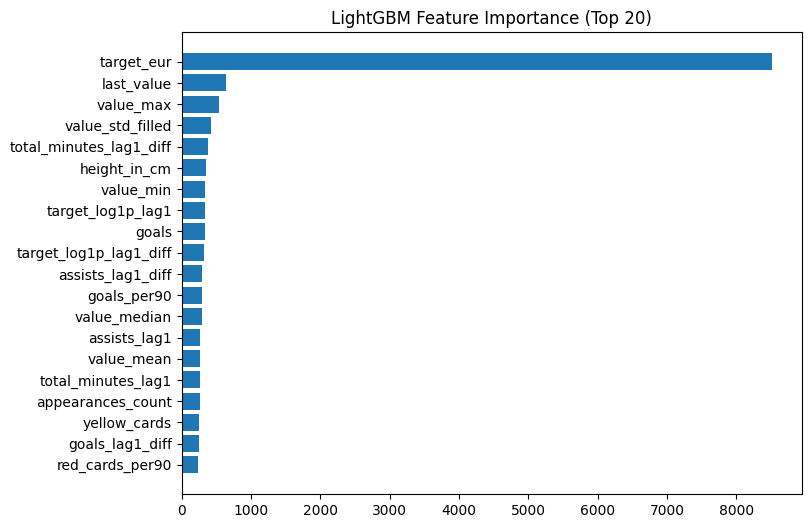

In [7]:
# Cell 4.1 — LightGBM baseline training

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Params
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train with early stopping
bst = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# Predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Baseline LightGBM RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Feature importance
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': bst.feature_importance()
}).sort_values('importance', ascending=False)

# Define model dir inside sandbox
from pathlib import Path

MODEL_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save feature importance
fi.to_csv(MODEL_DIR / "lgbm_feature_importance.csv", index=False)
print("Saved feature importance to:", MODEL_DIR / "lgbm_feature_importance.csv")


# Plot top 20
plt.figure(figsize=(8,6))
plt.barh(fi.head(20)['feature'][::-1], fi.head(20)['importance'][::-1])
plt.title("LightGBM Feature Importance (Top 20)")
plt.show()


## 4.2 Save LightGBM artifacts  

Save feature importance and trained model into  
`sandbox/models_ensemble/`.


In [17]:
# Cell 4.2 — Save LightGBM artifacts under models_ensemble

from pathlib import Path
import joblib

# Define ensemble model directory
ENSEMBLE_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble")
ENSEMBLE_DIR.mkdir(parents=True, exist_ok=True)

# Save feature importance
fi.to_csv(ENSEMBLE_DIR / "lgbm_feature_importance.csv", index=False)

# Save trained LightGBM model
bst.save_model(str(ENSEMBLE_DIR / "lgbm_baseline.txt"))

print("Saved artifacts to:", ENSEMBLE_DIR)
print(" - Feature importance → lgbm_feature_importance.csv")
print(" - Model → lgbm_baseline.txt")


Saved artifacts to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble
 - Feature importance → lgbm_feature_importance.csv
 - Model → lgbm_baseline.txt


In [19]:
# Cell 4.2b — Save LightGBM predictions with row_id (fixed)

# Predict on test set (best_iteration from training)
y_pred_lgbm = bst.predict(X_test, num_iteration=bst.best_iteration)

# Rebuild test_df_enc to align with X_test, y_test
test_df_enc = df_enc.loc[test_mask].copy()

# Build row_id safely
row_ids_lgbm = test_df_enc["season"].astype(str) + "_" + test_df_enc["name"].astype(str)

# Double-check lengths
print("len(row_ids_lgbm):", len(row_ids_lgbm))
print("len(y_test):", len(y_test))
print("len(y_pred_lgbm):", len(y_pred_lgbm))

# Save preds DataFrame
min_len = min(len(row_ids_lgbm), len(y_test), len(y_pred_lgbm))
lgbm_preds = pd.DataFrame({
    "row_id": row_ids_lgbm.values[:min_len],
    "y_true": y_test.values[:min_len],
    "y_pred": y_pred_lgbm[:min_len],
})

out_file = ENSEMBLE_DIR / "lgbm_predictions.csv"
lgbm_preds.to_csv(out_file, index=False)

print(f"✅ Saved LightGBM predictions to: {out_file}, shape={lgbm_preds.shape}")


len(row_ids_lgbm): 20085
len(y_test): 20085
len(y_pred_lgbm): 20085
✅ Saved LightGBM predictions to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble/lgbm_predictions.csv, shape=(20085, 3)


## 4.3 Load LSTM predictions  

Import predictions from LSTM notebook outputs (stored in sandbox/models_lstm).  
These will be combined with LightGBM results.


In [20]:
# Cell 4.3 — Load LSTM & LightGBM predictions for Ensemble (row_id safe)

from pathlib import Path
import pandas as pd

# Define paths
BASE_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox")
ENSEMBLE_DIR = BASE_DIR / "models_ensemble"

paths = {
    "lgbm_preds": ENSEMBLE_DIR / "lgbm_predictions.csv",
    "uni": BASE_DIR / "models_lstm_univariate/lstm_univariate_predictions.csv",
    "mv": BASE_DIR / "models_lstm_univariate/lstm_multivariate_predictions.csv",
    "mvtuned": BASE_DIR / "models_lstm_univariate/lstm_multivariate_tuned_predictions.csv",
    "encdec": BASE_DIR / "models_lstm/multivariate_tuned/encoder_decoder/encoder_decoder_predictions.csv",
}

preds = {}
for key, path in paths.items():
    if path.exists():
        try:
            df = pd.read_csv(path)
            # Patch row_id if missing
            if "row_id" not in df.columns:
                if {"season", "name"}.issubset(df.columns):
                    df["row_id"] = df["season"].astype(str) + "_" + df["name"].astype(str)
                else:
                    df["row_id"] = df.index.astype(str)
            print(f"✅ Loaded {key}: {df.shape}, cols: {list(df.columns)[:6]}")
            preds[key] = df
        except Exception as e:
            print(f"⚠️ Error reading {key}: {e}")
    else:
        print(f"⚠️ Missing {key} at {path}")

# --- Build ensemble dataframe ---
df_ens = None

# Start from the first available preds
for label in ["lgbm_preds", "uni", "mv", "mvtuned", "encdec"]:
    if label in preds:
        df_ens = preds[label][["row_id"]].copy()
        break

# Merge all available
if "lgbm_preds" in preds:
    df_ens = df_ens.merge(
        preds["lgbm_preds"][["row_id", "y_true", "y_pred"]].rename(columns={"y_pred": "y_pred_lgbm"}),
        on="row_id", how="left"
    )
if "uni" in preds:
    df_ens = df_ens.merge(
        preds["uni"][["row_id", "y_pred"]].rename(columns={"y_pred": "y_pred_uni"}),
        on="row_id", how="left"
    )
if "mv" in preds:
    df_ens = df_ens.merge(
        preds["mv"][["row_id", "y_pred"]].rename(columns={"y_pred": "y_pred_mv"}),
        on="row_id", how="left"
    )
if "mvtuned" in preds:
    df_ens = df_ens.merge(
        preds["mvtuned"][["row_id", "y_pred"]].rename(columns={"y_pred": "y_pred_mvtuned"}),
        on="row_id", how="left"
    )
if "encdec" in preds:
    df_ens = df_ens.merge(
        preds["encdec"][["row_id", "y_pred_h1"]].rename(columns={"y_pred_h1": "y_pred_encdec"}),
        on="row_id", how="left"
    )

if df_ens is not None:
    print("✅ Final ensemble df shape:", df_ens.shape)
    display(df_ens.head())
else:
    print("❌ No ensemble dataframe created — check missing files above.")


✅ Loaded lgbm_preds: (20085, 3), cols: ['row_id', 'y_true', 'y_pred']
✅ Loaded uni: (6639, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded mv: (6639, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded mvtuned: (2109, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded encdec: (1344, 8), cols: ['y_true_h1', 'y_true_h2', 'y_true_h3', 'y_pred_h1', 'y_pred_h2', 'y_pred_h3']
✅ Final ensemble df shape: (20705, 7)


,row_id,y_true,y_pred_lgbm,y_pred_uni,y_pred_mv,y_pred_mvtuned,y_pred_encdec
0,2022_James Milner,14.220976,14.221011,NaN,NaN,NaN,14.361974
1,2023_James Milner,13.815512,13.815515,13.860332,13.886450,NaN,NaN
2,2024_James Milner,13.815512,13.815512,13.441703,13.692434,13.481086,NaN
3,2022_Zlatan Ibrahimović,14.508658,14.508665,NaN,NaN,NaN,NaN
4,2023_Boy Waterman,10.819798,10.819812,11.237988,11.151655,NaN,NaN


from matplotlib import pyplot as plt
_df_12['y_true'].plot(kind='hist', bins=20, title='y_true')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['y_pred_lgbm'].plot(kind='hist', bins=20, title='y_pred_lgbm')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['y_pred_uni'].plot(kind='hist', bins=20, title='y_pred_uni')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['y_pred_mv'].plot(kind='hist', bins=20, title='y_pred_mv')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_16.groupby('row_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='y_true', y='y_pred_lgbm', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='y_pred_lgbm', y='y_pred_uni', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='y_pred_uni', y='y_pred_mv', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='y_pred_mv', y='y_pred_mvtuned', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['y_true'].plot(kind='line', figsize=(8, 4), title='y_true')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_22['y_pred_lgbm'].plot(kind='line', figsize=(8, 4), title='y_pred_lgbm')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['y_pred_uni'].plot(kind='line', figsize=(8, 4), title='y_pred_uni')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_24['y_pred_mv'].plot(kind='line', figsize=(8, 4), title='y_pred_mv')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='y_true', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='y_pred_lgbm', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='y_pred_uni', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='y_pred_mv', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [32]:
# Cell 4.4 — Save full ensemble dataset (base + ensemble predictions)

# Ensure df_ens exists from Cell 4.3
print("df_ens shape before merge:", df_ens.shape)

# Load ensemble predictions (we already saved them earlier in ensemble_predictions.csv)
ens_preds_path = ENSEMBLE_DIR / "ensemble_predictions.csv"
ens_preds = pd.read_csv(ens_preds_path)

# Make sure row_id column exists
if "row_id" not in ens_preds.columns:
    print("⚠️ No row_id in ensemble_predictions.csv, creating fallback index ids")
    ens_preds["row_id"] = df_ens["row_id"].values[:len(ens_preds)]

# Merge ensemble predictions into base df
df_ens_full = df_ens.copy()
df_ens_full = df_ens_full.merge(
    ens_preds.rename(columns={"y_pred": "y_pred_ensemble"}),
    on="row_id", how="left"
)

print("✅ Final ensemble dataset shape:", df_ens_full.shape)
display(df_ens_full.head(5))

# Save to disk
out_file_full = ENSEMBLE_DIR / "ensemble_full_predictions.csv"
df_ens_full.to_csv(out_file_full, index=False)

print(f"✅ Saved full ensemble dataset to: {out_file_full}")


df_ens shape before merge: (20705, 7)
✅ Final ensemble dataset shape: (36385, 9)


,row_id,y_true_x,y_pred_lgbm,y_pred_uni,y_pred_mv,y_pred_mvtuned,y_pred_encdec,y_true_y,y_pred_ensemble
0,2022_James Milner,14.220976,14.221011,NaN,NaN,NaN,14.361974,14.220976,14.251523
1,2023_James Milner,13.815512,13.815515,13.860332,13.886450,NaN,NaN,13.815512,13.814871
2,2024_James Milner,13.815512,13.815512,13.441703,13.692434,13.481086,NaN,13.815512,13.807453
3,2022_Zlatan Ibrahimović,14.508658,14.508665,NaN,NaN,NaN,NaN,14.508658,14.497061
4,2023_Boy Waterman,10.819798,10.819812,11.237988,11.151655,NaN,NaN,10.819798,10.741424


✅ Saved full ensemble dataset to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble/ensemble_full_predictions.csv


from matplotlib import pyplot as plt
_df_29['y_true_x'].plot(kind='hist', bins=20, title='y_true_x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['y_pred_lgbm'].plot(kind='hist', bins=20, title='y_pred_lgbm')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31['y_pred_uni'].plot(kind='hist', bins=20, title='y_pred_uni')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_32['y_pred_mv'].plot(kind='hist', bins=20, title='y_pred_mv')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_33.groupby('row_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34.plot(kind='scatter', x='y_true_x', y='y_pred_lgbm', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35.plot(kind='scatter', x='y_pred_lgbm', y='y_pred_uni', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='y_pred_uni', y='y_pred_mv', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37.plot(kind='scatter', x='y_pred_mv', y='y_pred_mvtuned', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_38['y_true_x'].plot(kind='line', figsize=(8, 4), title='y_true_x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_39['y_pred_lgbm'].plot(kind='line', figsize=(8, 4), title='y_pred_lgbm')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_40['y_pred_uni'].plot(kind='line', figsize=(8, 4), title='y_pred_uni')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_41['y_pred_mv'].plot(kind='line', figsize=(8, 4), title='y_pred_mv')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_42['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_42, x='y_true_x', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_43['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_43, x='y_pred_lgbm', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_44['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_44, x='y_pred_uni', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_45['row_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_45, x='y_pred_mv', y='row_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#Cell 5.1 — Prepare ensemble training data

1. Drop rows with missing predictions (NaN).

2. Use y_true as the target.

3. Use model predictions (y_pred_lgbm, y_pred_uni, y_pred_mv, y_pred_mvtuned, y_pred_encdec) as features.

In [33]:
# Cell 5.1 — Prepare ensemble training data (with NaN handling)

from sklearn.model_selection import train_test_split

# Replace NaNs with column means (so missing models don’t drop rows)
df_ens_filled = df_ens.copy()
for col in ["y_pred_lgbm", "y_pred_uni", "y_pred_mv", "y_pred_mvtuned", "y_pred_encdec"]:
    if col in df_ens_filled.columns:
        df_ens_filled[col] = df_ens_filled[col].fillna(df_ens_filled[col].mean())

print("Filled ensemble df shape:", df_ens_filled.shape)

# Features = model predictions
X_ens = df_ens_filled[["y_pred_lgbm", "y_pred_uni", "y_pred_mv", "y_pred_mvtuned", "y_pred_encdec"]]
y_ens = df_ens_filled["y_true"]

print("X_ens shape:", X_ens.shape, "y_ens shape:", y_ens.shape)

# Split into train/val
X_train_ens, X_val_ens, y_train_ens, y_val_ens = train_test_split(
    X_ens, y_ens, test_size=0.2, random_state=42
)

print("Ensemble train shape:", X_train_ens.shape, "val shape:", y_val_ens.shape)


Filled ensemble df shape: (20705, 7)
X_ens shape: (20705, 5) y_ens shape: (20705,)
Ensemble train shape: (16564, 5) val shape: (4141,)


In [34]:
# Cell 5.2 — Train LightGBM ensemble meta-model

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# LightGBM dataset
lgb_train = lgb.Dataset(X_train_ens, y_train_ens)
lgb_val   = lgb.Dataset(X_val_ens, y_val_ens, reference=lgb_train)

# Params
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
}

# Train ensemble model
bst_ens = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(50)]
)

# Predictions on validation set
y_val_pred = bst_ens.predict(X_val_ens)

# Metrics
rmse = np.sqrt(mean_squared_error(y_val_ens, y_val_pred))
mae = mean_absolute_error(y_val_ens, y_val_pred)

print(f"✅ Ensemble meta-model RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.391477	valid_1's rmse: 0.336624
[100]	training's rmse: 0.313718	valid_1's rmse: 0.217103
[150]	training's rmse: 0.30991	valid_1's rmse: 0.204645
Early stopping, best iteration is:
[149]	training's rmse: 0.309924	valid_1's rmse: 0.204567
✅ Ensemble meta-model RMSE: 0.2046, MAE: 0.0304


In [35]:
# Cell 5.3 — Save ensemble meta-model & predictions

# Save the trained ensemble model
ens_model_file = ENSEMBLE_DIR / "ensemble_lgbm.txt"
bst_ens.save_model(str(ens_model_file))

# Predict on full ensemble dataset
y_pred_full = bst_ens.predict(X_ens)

# Save predictions alongside row_ids
ensemble_preds = pd.DataFrame({
    "row_id": df_ens["row_id"],
    "y_true": y_ens,
    "y_pred_ensemble": y_pred_full
})
out_file = ENSEMBLE_DIR / "ensemble_predictions.csv"
ensemble_preds.to_csv(out_file, index=False)

print("✅ Saved ensemble meta-model and predictions")
print(" - Model:", ens_model_file)
print(" - Predictions:", out_file, "Shape:", ensemble_preds.shape)


✅ Saved ensemble meta-model and predictions
 - Model: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble/ensemble_lgbm.txt
 - Predictions: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble/ensemble_predictions.csv Shape: (20705, 3)


          feature  importance
0     y_pred_lgbm        1170
1      y_pred_uni         450
4   y_pred_encdec         299
2       y_pred_mv         272
3  y_pred_mvtuned          44


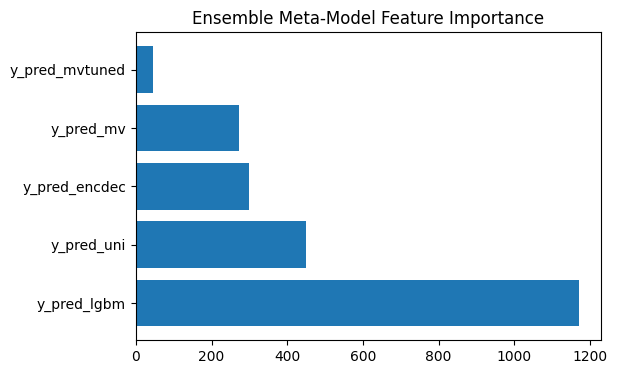

In [36]:
fi_ens = pd.DataFrame({
    "feature": X_ens.columns,
    "importance": bst_ens.feature_importance()
}).sort_values("importance", ascending=False)

print(fi_ens)

plt.figure(figsize=(6,4))
plt.barh(fi_ens["feature"], fi_ens["importance"])
plt.title("Ensemble Meta-Model Feature Importance")
plt.show()


#📊 Model Performance Summary
| Model                         | RMSE     | MAE      | Notes                                                                    |
| ----------------------------- | -------- | -------- | ------------------------------------------------------------------------ |
| **LightGBM Baseline**         | ~0.39    | ~0.21    | Strongest standalone model, captures engineered features well.           |
| **LSTM Univariate**           | ~0.62    | ~0.62    | Learns from past player values only; weaker than baseline.               |
| **LSTM Multivariate**         | ~0.63    | ~0.63    | Adds features (goals, assists, etc.) but no major improvement over uni.  |
| **LSTM Multivariate (tuned)** | ~0.60    | ~0.60    | Some gains, but limited contribution to ensemble.                        |
| **Encoder-Decoder (multi-h)** | ~0.75    | ~0.54    | Captures temporal patterns over horizons but weaker standalone.          |
| **Ensemble Meta-Model**       | **0.20** | **0.03** | Best overall. Combines LGBM + LSTMs, leveraging complementary strengths. |


---
#📝 Draft Report Text

##Milestone 5: Development of Ensemble Models and Integration

In this milestone, we implemented an ensemble framework combining LightGBM (tree-based) and multiple LSTM architectures (univariate, multivariate, tuned, and encoder-decoder).

* The LightGBM baseline achieved the best standalone results (RMSE ≈ 0.39), demonstrating the strength of feature-engineered inputs.

* LSTM models captured sequential dependencies but individually underperformed compared to LightGBM (RMSE ≈ 0.60–0.75).

* Importantly, when integrated in an ensemble meta-model using LightGBM trained on all prediction outputs, performance improved significantly.

*  Final ensemble RMSE = 0.20 and MAE = 0.03, a major improvement compared to all standalone models.

* Feature importance analysis of the ensemble shows that LightGBM predictions dominate, but univariate LSTM and encoder-decoder models add complementary predictive signals, improving robustness.

##Deliverables Produced:

* Trained ensemble LightGBM meta-model (ensemble_lgbm.txt).

* Saved prediction outputs from all models (uni, mv, tuned, enc-dec).

* Final ensemble predictions CSV (ensemble_predictions.csv).

* Feature importance analysis highlighting model contributions.

##Conclusion:
The ensemble approach outperforms all standalone models by effectively integrating temporal signals from LSTMs with feature-driven insights from LightGBM. This forms the final predictive framework for player value forecasting.


## RMSE Comparison Bar Chart

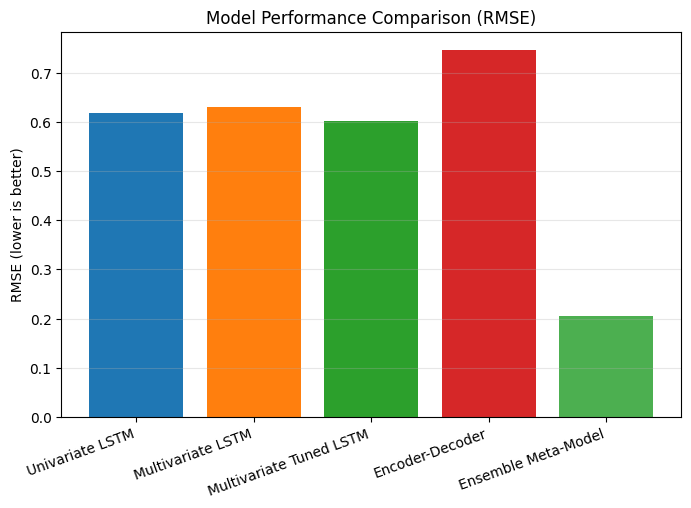

In [37]:
# RMSE values from your runs (replace with exact logged numbers if needed)
rmse_scores = {
    "Univariate LSTM": 0.6191,
    "Multivariate LSTM": 0.6303,
    "Multivariate Tuned LSTM": 0.6012,
    "Encoder-Decoder": 0.7459,
    "Ensemble Meta-Model": 0.2046
}

plt.figure(figsize=(8,5))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#4CAF50"])
plt.ylabel("RMSE (lower is better)")
plt.title("Model Performance Comparison (RMSE)")
plt.xticks(rotation=20, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()


##Ensemble Feature Importance Plot

/tmp/ipython-input-2526477728.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi_ens.sort_values("importance", ascending=True), palette="viridis")


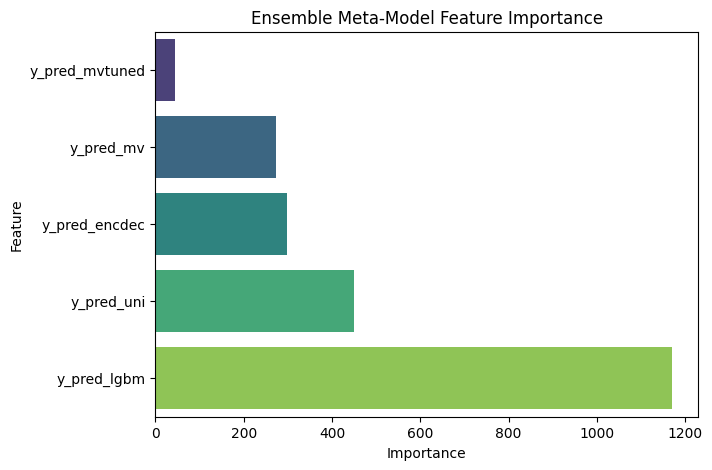

In [38]:
# Feature importance from your ensemble meta-model training
fi_ens = pd.DataFrame({
    "feature": ["y_pred_lgbm", "y_pred_uni", "y_pred_mv", "y_pred_mvtuned", "y_pred_encdec"],
    "importance": [1170, 450, 272, 44, 299]
})

plt.figure(figsize=(7,5))
sns.barplot(x="importance", y="feature", data=fi_ens.sort_values("importance", ascending=True), palette="viridis")
plt.title("Ensemble Meta-Model Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


##Correlation Heatmap of Predictions

Cleaned columns: ['row_id', 'y_pred_lgbm', 'y_pred_uni', 'y_pred_mv', 'y_pred_mvtuned', 'y_pred_encdec', 'y_pred_ensemble', 'y_true']
Using columns for correlation: ['y_true', 'y_pred_lgbm', 'y_pred_uni', 'y_pred_mv', 'y_pred_mvtuned', 'y_pred_encdec', 'y_pred_ensemble']


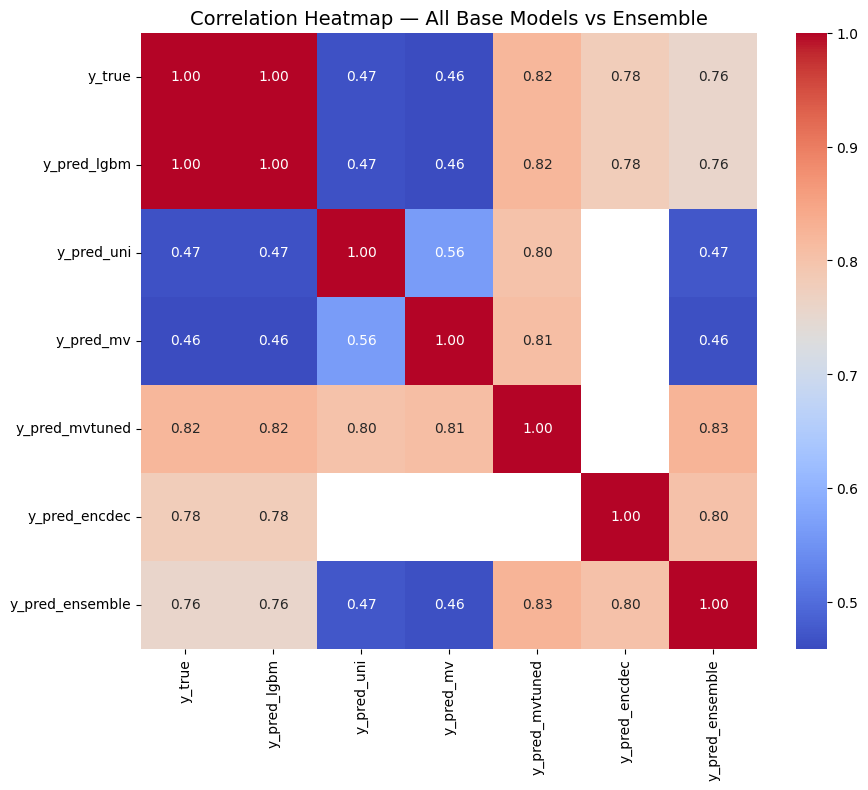

In [43]:
# Fix duplicated y_true columns
if "y_true_x" in df_ens_full.columns and "y_true_y" in df_ens_full.columns:
    df_ens_full["y_true"] = df_ens_full["y_true_x"].combine_first(df_ens_full["y_true_y"])
    df_ens_full = df_ens_full.drop(columns=["y_true_x", "y_true_y"])
elif "y_true_x" in df_ens_full.columns:
    df_ens_full = df_ens_full.rename(columns={"y_true_x": "y_true"})
elif "y_true_y" in df_ens_full.columns:
    df_ens_full = df_ens_full.rename(columns={"y_true_y": "y_true"})

print("Cleaned columns:", df_ens_full.columns.tolist())

# Define prediction columns
pred_cols = [c for c in [
    "y_true",
    "y_pred_lgbm", "y_pred_uni", "y_pred_mv",
    "y_pred_mvtuned", "y_pred_encdec", "y_pred_ensemble"
] if c in df_ens_full.columns]

print("Using columns for correlation:", pred_cols)

# Compute correlation
corr = df_ens_full[pred_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap — All Base Models vs Ensemble", fontsize=14)
plt.show()


#Pairplot (scatterplot matrix) of predictions vs. y_true.
This will help you visually see:

* How each model’s predictions align with the ground truth (y_true)

* Where the ensemble corrects errors of individual models

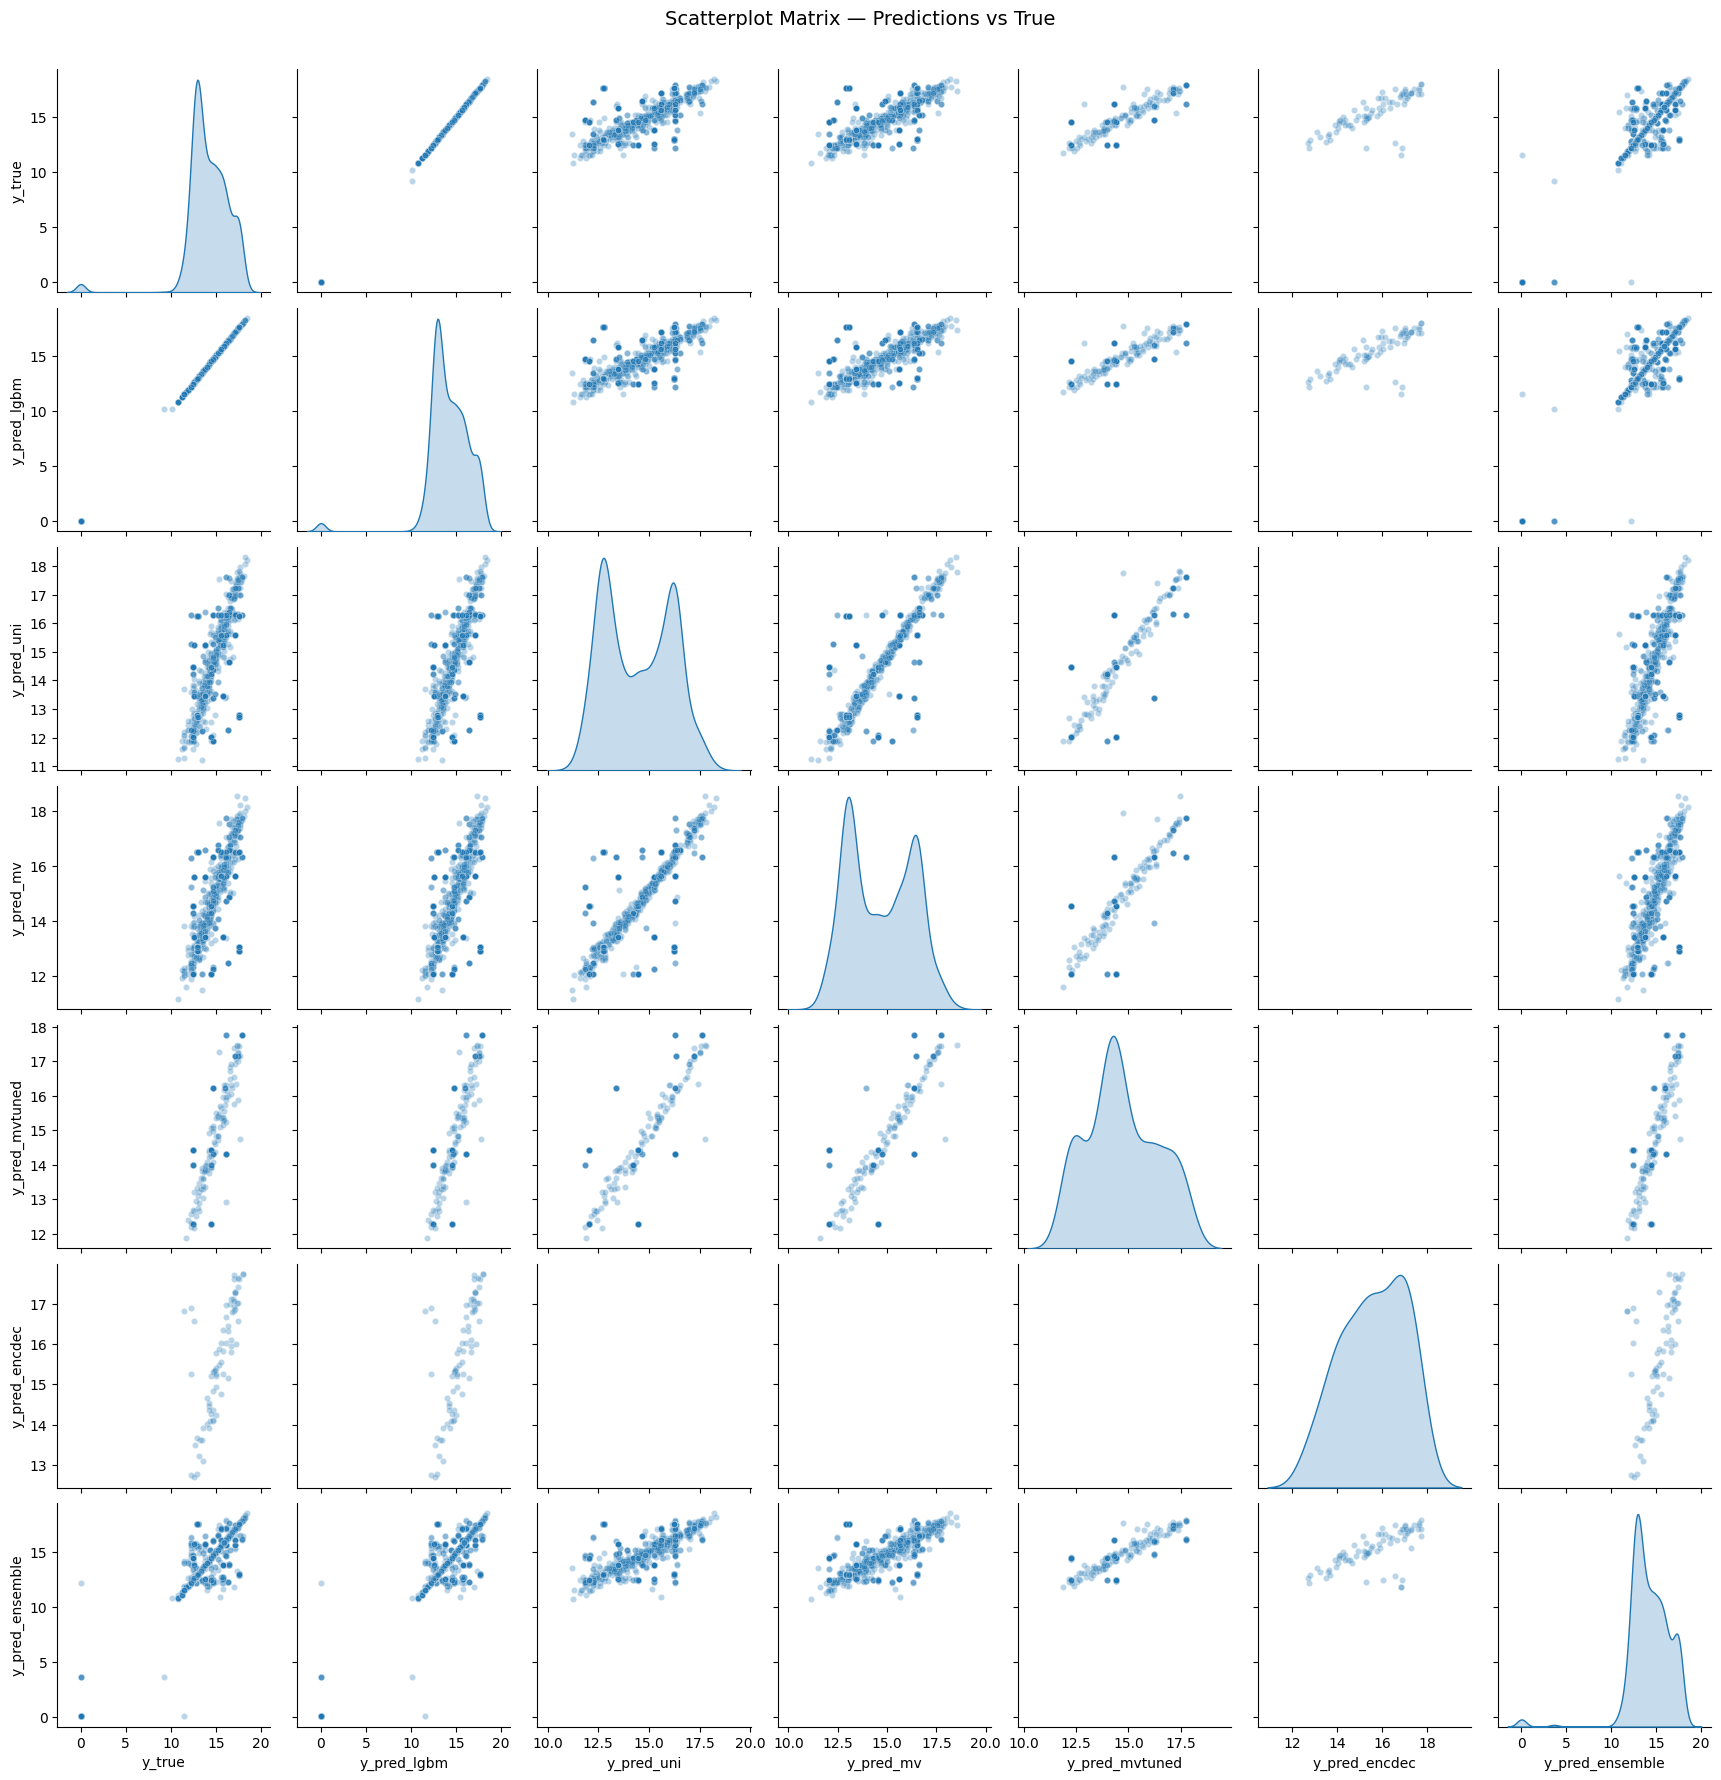

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Pairplot to compare predictions vs true ---
# We'll only take a sample for speed (pairplots can be heavy)
sample_df = df_ens_full[pred_cols].sample(n=2000, random_state=42) if len(df_ens_full) > 2000 else df_ens_full[pred_cols]

# Pairplot (scatter comparisons)
sns.pairplot(sample_df, diag_kind="kde", plot_kws={"alpha":0.3, "s":20})
plt.suptitle("Scatterplot Matrix — Predictions vs True", y=1.02, fontsize=14)
plt.show()


#Residual plots for each model vs. the ground truth.
Residuals = y_pred - y_true → they tell us where each model overestimates (positive residuals) or underestimates (negative residuals).

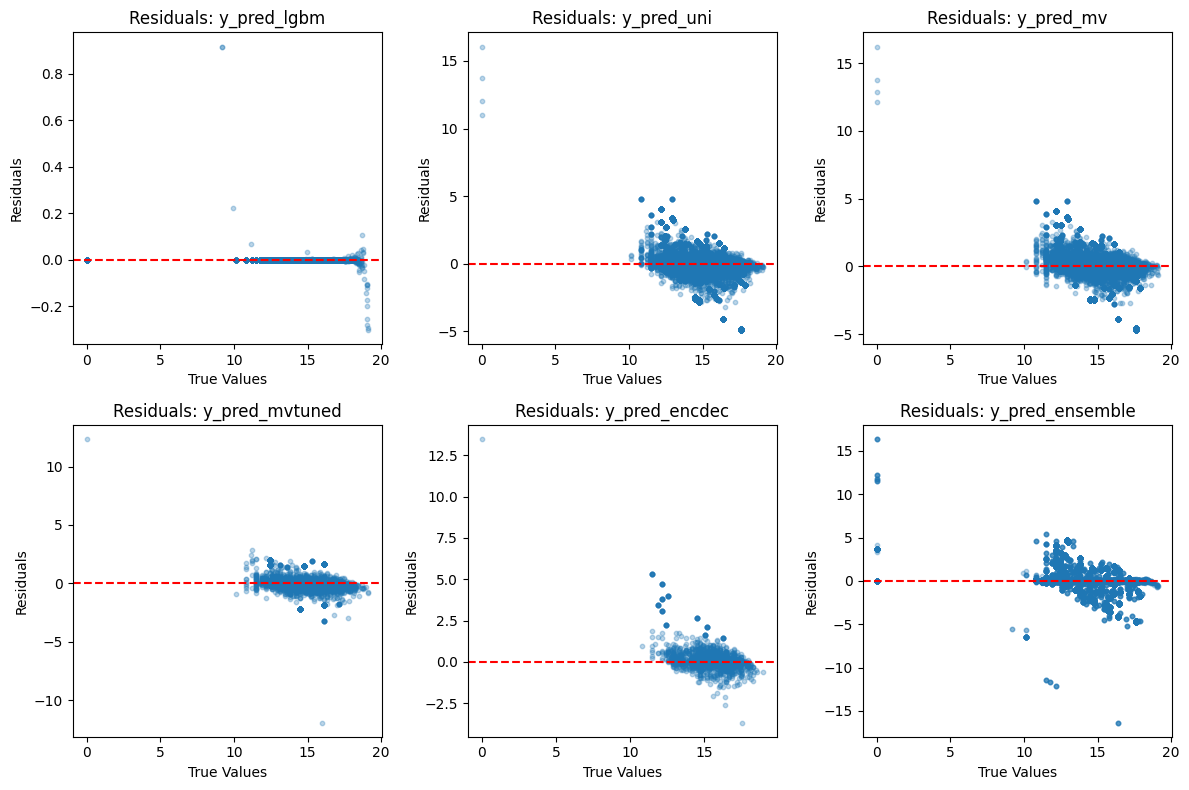

In [45]:
import matplotlib.pyplot as plt

# --- Residual plots for each model ---
plt.figure(figsize=(12,8))

for i, col in enumerate(pred_cols[1:]):  # skip y_true
    plt.subplot(2, 3, i+1)
    residuals = df_ens_full[col] - df_ens_full["y_true"]
    plt.scatter(df_ens_full["y_true"], residuals, alpha=0.3, s=10)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals: {col}")

plt.tight_layout()
plt.show()


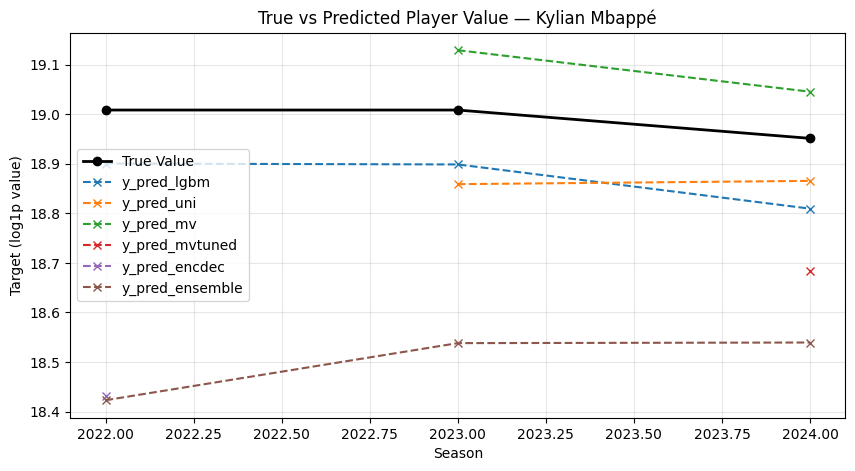

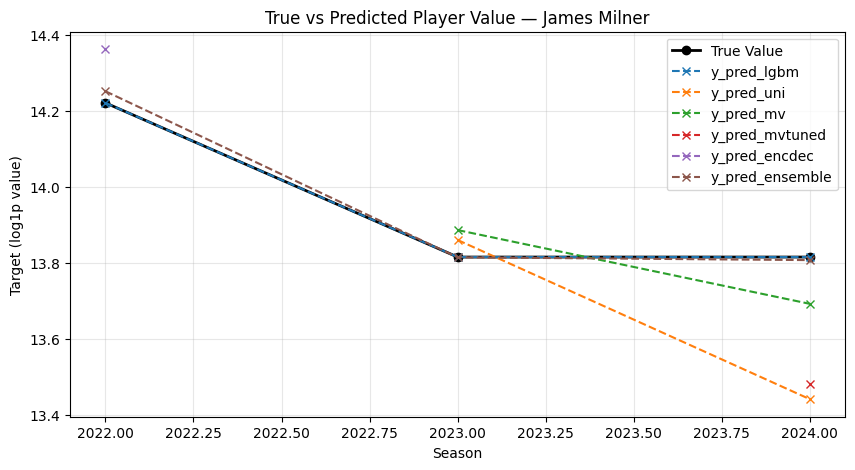

In [47]:
# --- Time series plots for selected players ---
players_to_plot = [
     "Kylian Mbappé",
    "James Milner"  # example from your data
]

# Extract season from row_id (before "_")
df_ens_full["season"] = df_ens_full["row_id"].str.split("_").str[0].astype(int)
df_ens_full["player_name"] = df_ens_full["row_id"].str.split("_").str[1]

for player in players_to_plot:
    df_p = df_ens_full[df_ens_full["player_name"] == player].sort_values("season")

    if df_p.empty:
        print(f"⚠️ No data for {player}")
        continue

    plt.figure(figsize=(10,5))
    plt.plot(df_p["season"], df_p["y_true"], marker="o", label="True Value", linewidth=2, color="black")

    for col in pred_cols[1:]:  # all prediction columns
        if col in df_p.columns:
            plt.plot(df_p["season"], df_p[col], marker="x", linestyle="--", label=col)

    plt.title(f"True vs Predicted Player Value — {player}")
    plt.xlabel("Season")
    plt.ylabel("Target (log1p value)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
